In [1]:
import pandas as pd

nlp = pd.read_csv('/Users/selinwork/Documents/Ironhack/Ironhack_Week_9/Kaggle_Ok_Cupid/nlp_data.csv')

In [2]:
data = nlp.copy()

In [3]:
# Combining all user information into one profile column for better NLP processing
data['user_profile'] = data.apply(
    lambda row: f"Essays: {row['self_summary']} {row['life_work']} {row['skills']} {row['first_notice']} "
                f"Favorites: {row['favorites']} Can't Live Without: {row['cant_live_without']} "
                f"Thinking About: {row['thinking_about']} Friday Night: {row['friday_night']} "
                f"Private Admission: {row['private_admission']} Message Me: {row['message_me_if']}. "
                f"Demographics: Gender: {row['gender']}, Age: {row['age']}, "
                f"Education: {row['education']}, Income: {row['income']}, "
                f"Job: {row['job']}, Smoking: {row['smoking']}, Drinking: {row['drinks']}, "
                f"Drugs: {row['drugs']}, Language: {row['language']}, Kids: {row['kids']}, "
                f"Behavior: Ghosting Experience: {row['ghostingexp']}, Reflect Before Swipe: {row['reflectbeforeswipe']}, "
                f"Conscious Module: {row['consciousmodule']}.",
    axis=1
)

In [4]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

# Download necessary NLTK data
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing function to user profiles
data['user_profile'] = data['user_profile'].apply(preprocess_text)



[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/selinwork/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/selinwork/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/selinwork/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
data['user_profile'].head()

0    essay would love think kind intellectual eithe...
1    essay chef mean 1 workaholic 2 love cook regar...
2    essay ashamed much writing public text online ...
3    essay work library go school reading thing wri...
4    essay hey going currently vague profile know c...
Name: user_profile, dtype: object

In [10]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Generate embeddings in batches
def embeddings(text):
    return model.encode(text, convert_to_numpy=True, normalize_embeddings=True)

# Apply to all user profiles
data['embeddings'] = data['user_profile'].apply(embeddings)

# Convert to NumPy array
embeddings = np.vstack(data['embeddings'].to_numpy())

# Check shape
print(f"Embedding shape: {embeddings.shape}")  # Should be (num_users, 384)

Embedding shape: (59946, 384)


In [12]:
# Perform KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
data['cluster'] = kmeans.fit_predict(embeddings)


In [13]:
inertias = []
range_of_clusters = range(1, 11)

for k in range_of_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    inertias.append(kmeans.inertia_)

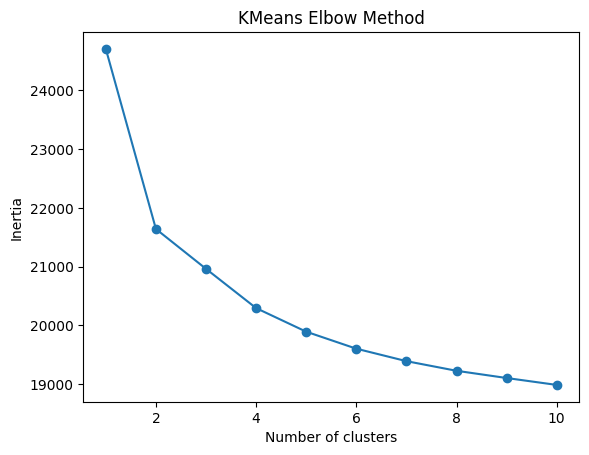

In [14]:
# Plot the elbow method

import matplotlib.pyplot as plt

plt.plot(range_of_clusters, inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('KMeans Elbow Method')
plt.show()

In [15]:
from kneed import KneeLocator

kl = KneeLocator(range_of_clusters, inertias, curve='convex', direction='decreasing')
optimal_clusters = kl.knee

print(f'Optimal number of clusters: {optimal_clusters}')

Optimal number of clusters: 4


In [17]:
embeddings = np.vstack(data['embeddings'].to_numpy())

# Perform KMeans clustering based on the optimal number of clusters
kmeans = KMeans(n_clusters=4, random_state=42)
data['cluster'] = kmeans.fit_predict(embeddings)

# Check cluster distributions
print(data.groupby('cluster').size())

cluster
0    19794
1    14044
2    21587
3     4521
dtype: int64


In [65]:
# I want to see the distribution of the clusters with the model sentiment analysis. with anger, disgust,happioness, sadness, fear, surprise.

from textblob import TextBlob

# Define sentiment analysis function
def sentiment_analysis(text):
    blob = TextBlob(text)
    return blob.sentiment

# Apply sentiment analysis to user profiles
data['sentiment'] = data['user_profile'].apply(sentiment_analysis)

# Extract polarity and subjectivity
data['polarity'] = data['sentiment'].apply(lambda x: x.polarity)
data['subjectivity'] = data['sentiment'].apply(lambda x: x.subjectivity)

# Check sentiment distributions
print(data.groupby('cluster')[['polarity', 'subjectivity']].mean())


         polarity  subjectivity
cluster                        
0        0.187075      0.513534
1        0.178420      0.500755
2        0.160247      0.500993
3        0.134565      0.500089


In [66]:
# explain the polarity and subjectivity and give me more information about the clusters.

# Define function to extract most common words
def extract_words(text):
    words = word_tokenize(text)
    words = [word for word in words if word.isalpha()]
    return words

# Apply to user profiles
data['words'] = data['user_profile'].apply(extract_words)

# Check most common words
from collections import Counter

common_words = Counter()
for words in data['words']:
    common_words.update(words)

print(common_words.most_common(10))


[('comment', 175770), ('like', 139730), ('love', 124230), ('friend', 96514), ('kid', 94759), ('favorite', 92403), ('good', 90166), ('music', 84421), ('live', 83480), ('time', 82299)]
